# **Data Preparation For Classification**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from scipy.stats import entropy
import sys
sys.path.append('..')
from utils import center_and_scale, correlations, plot_correlations
from sklearn.preprocessing import StandardScaler


In [3]:
races_df = pd.read_csv('../dataset/cleaned_races.csv')

In [4]:
races_df.columns

Index(['_url', 'name', 'points', 'length', 'climb_total', 'profile',
       'startlist_quality', 'position', 'cyclist', 'cyclist_age', 'is_tarmac',
       'cyclist_team', 'start_date', 'duration'],
      dtype='object')

## Data Cleaning for Classification

Given that we leave pending the drop of stages with climb total or profile null, we firstly perform that in order to simplify the classification task

In [5]:
initial_rows = len(races_df)
races_df.dropna(subset=['climb_total', 'profile'], inplace=True)
rows_dropped = initial_rows - len(races_df)
print(f"Number of rows dropped: {rows_dropped}")


Number of rows dropped: 180556


Add cyclists number to the dataframe, is a support column used to compute relative positions

In [6]:
# Count the number of occurrences of each _url
url_counts = races_df['_url'].value_counts().reset_index()
url_counts.columns = ['_url', 'cyclist_number']

# Merge the counts back to the original dataframe
races_df = races_df.merge(url_counts, on='_url', how='left')

Given that the task is binary on position classifing in top_20 and rest of the cyclists, on professor advice, we decided to drop stages with less then

In [7]:
initial_rows = len(races_df)
races_df = races_df[races_df['cyclist_number'] >= 25]
rows_dropped = initial_rows - len(races_df)
print(f"Number of rows dropped: {rows_dropped}") 

Number of rows dropped: 56


In [8]:
races_df["cyclist_number"].describe()

count    409004.000000
mean        161.461717
std          24.616266
min          33.000000
25%         147.000000
50%         165.000000
75%         179.000000
max         210.000000
Name: cyclist_number, dtype: float64

## Feature Engineering

### ```top_20```  column

This columns represents the classification label, is 1 if position is smaller or equal to 20 and is 

In [9]:
races_df['top_20'] = races_df['position'].apply(lambda x: 1 if x <= 20 else 0)

In [10]:
races_df['top_20'].value_counts()
# Print value counts
value_counts = races_df['top_20'].value_counts()
print("Value Counts:")
print(value_counts)

# Print percentages
percentages = races_df['top_20'].value_counts(normalize=True) * 100
print("\nPercentages:")
print(percentages)


Value Counts:
top_20
0    354195
1     54809
Name: count, dtype: int64

Percentages:
top_20
0    86.599398
1    13.400602
Name: proportion, dtype: float64


Check number of data in train + validation and test datasets

In [11]:
# Convert the start_date column to datetime format
races_df['start_date'] = pd.to_datetime(races_df['start_date'])

# Count the number of races before 2022
races_before_2022 = races_df[races_df['start_date'] < '2022-01-01']

# Count the number of races after 2022
races_after_2022 = races_df[races_df['start_date'] >= '2022-01-01']

# Calculate the percentage of races before and after 2022
total_races = races_df.shape[0]
percentage_before_2022 = (races_before_2022.shape[0] / total_races) * 100
percentage_after_2022 = (races_after_2022.shape[0] / total_races) * 100

print(f"Training + Validation size: {races_before_2022.shape[0]} ({percentage_before_2022:.2f}%)")
print(f"Test Set size: {races_after_2022.shape[0]} ({percentage_after_2022:.2f}%)")

Training + Validation size: 373598 (91.34%)
Test Set size: 35406 (8.66%)


Let's see also stratification in this datasets

In [12]:
print(races_before_2022["top_20"].value_counts(normalize=True) * 100)
print(races_after_2022["top_20"].value_counts(normalize=True) * 100)


top_20
0    86.717809
1    13.282191
Name: proportion, dtype: float64
top_20
0    85.349941
1    14.650059
Name: proportion, dtype: float64


### ```cyclist_level```  column

This feature inserts at each races row the level of the relevant rider up to and including that day. The level is calculated in the following way

In [13]:
# sort races by cyclist name and start date
races_df = races_df.sort_values(by=["cyclist", "start_date"])

# compute weighted points for each stage
races_df["weighted_points"] = races_df["points"] * (1-(1+races_df["position"]) / races_df["cyclist_number"])

# compute career level
races_df["cyclist_level"] = (
    races_df.groupby("cyclist")["weighted_points"]
    .cumsum()
    .add(0)
)

# previous computations are cumulative and fill first value for each different cyclist with values from 
# previous one, so shift all and insert a 0 at beginning of each cyclist
races_df["cyclist_level"] = races_df.groupby("cyclist")["cyclist_level"].shift(fill_value=0)

races_df.drop(columns="weighted_points", inplace=True)

races_df[["_url","cyclist","start_date","position","cyclist_number","points","cyclist_level"]].head()


,_url,cyclist,start_date,position,cyclist_number,points,cyclist_level
41968,tour-de-france/1978/prologue,aad-van-den-hoek,1978-06-29,28,110,100.0,0.000000
117821,tour-de-france/1978/stage-1a,aad-van-den-hoek,1978-06-30,88,109,100.0,73.636364
174397,tour-de-france/1978/stage-1b,aad-van-den-hoek,1978-06-30,57,109,100.0,91.984987
331237,tour-de-france/1978/stage-2,aad-van-den-hoek,1978-07-01,47,108,100.0,138.773978
21609,tour-de-france/1978/stage-3,aad-van-den-hoek,1978-07-02,79,106,100.0,194.329534


### ```cyclist_experience```  column

This feature inserts at each races row the number of stages on which a cyclist participate to up that stage

In [14]:
# sort races by cyclist name and start date
races_df = races_df.sort_values(by=["cyclist", "start_date"])

# Compute cyclist experience, resetting for each cyclist
races_df["cyclist_experience"] = (
    races_df.groupby("cyclist").cumcount()  # count rows for each cyclist group
    .add(0)                                 # start from 0
)

races_df[["_url","cyclist","start_date","cyclist_experience", "cyclist_level"]].head(8)


,_url,cyclist,start_date,cyclist_experience,cyclist_level
41968,tour-de-france/1978/prologue,aad-van-den-hoek,1978-06-29,0,0.000000
117821,tour-de-france/1978/stage-1a,aad-van-den-hoek,1978-06-30,1,73.636364
174397,tour-de-france/1978/stage-1b,aad-van-den-hoek,1978-06-30,2,91.984987
331237,tour-de-france/1978/stage-2,aad-van-den-hoek,1978-07-01,3,138.773978
21609,tour-de-france/1978/stage-3,aad-van-den-hoek,1978-07-02,4,194.329534
274179,tour-de-france/1978/stage-5,aad-van-den-hoek,1978-07-04,5,218.857836
84,tour-de-france/1978/stage-6,aad-van-den-hoek,1978-07-05,6,240.555949
168634,tour-de-france/1978/stage-7,aad-van-den-hoek,1978-07-06,7,260.367270


### ```avg_relative_position```  column

This feature inserts at each races row the average relative position reached by the cyclists untill that stage

In [15]:
# sort races by cyclist name and start date
races_df = races_df.sort_values(by=["cyclist", "start_date"])

# compute relative position for each stage
races_df["relative_position"] = (races_df["position"] + 1) / races_df["cyclist_number"]

# compute relative position summation
races_df["relative_position_sum"] = (
    races_df.groupby("cyclist")["relative_position"]
    .cumsum()
    .shift(fill_value=0)  # shift to exclude the current stage
)

races_df["avg_relative_position"] = races_df["relative_position_sum"] / races_df["cyclist_experience"]

races_df["avg_relative_position"] = races_df["avg_relative_position"].fillna(0)
races_df["avg_relative_position"] = races_df["avg_relative_position"].replace([float('inf'), -float('inf')], 0)

races_df[["_url","cyclist","start_date","relative_position_sum","relative_position","avg_relative_position"]].head(8)

,_url,cyclist,start_date,relative_position_sum,relative_position,avg_relative_position
41968,tour-de-france/1978/prologue,aad-van-den-hoek,1978-06-29,0.000000,0.263636,0.000000
117821,tour-de-france/1978/stage-1a,aad-van-den-hoek,1978-06-30,0.263636,0.816514,0.263636
174397,tour-de-france/1978/stage-1b,aad-van-den-hoek,1978-06-30,1.080150,0.532110,0.540075
331237,tour-de-france/1978/stage-2,aad-van-den-hoek,1978-07-01,1.612260,0.444444,0.537420
21609,tour-de-france/1978/stage-3,aad-van-den-hoek,1978-07-02,2.056705,0.754717,0.514176
274179,tour-de-france/1978/stage-5,aad-van-den-hoek,1978-07-04,2.811422,0.783019,0.562284
84,tour-de-france/1978/stage-6,aad-van-den-hoek,1978-07-05,3.594441,0.801887,0.599073
168634,tour-de-france/1978/stage-7,aad-van-den-hoek,1978-07-06,4.396327,0.613208,0.628047


In [16]:
races_df.drop(columns="relative_position_sum", inplace=True)

In [17]:
races_df.columns

Index(['_url', 'name', 'points', 'length', 'climb_total', 'profile',
       'startlist_quality', 'position', 'cyclist', 'cyclist_age', 'is_tarmac',
       'cyclist_team', 'start_date', 'duration', 'cyclist_number', 'top_20',
       'cyclist_level', 'cyclist_experience', 'relative_position',
       'avg_relative_position'],
      dtype='object')

### ```avg_rel_position_profile```  column

Compute average relative position reached by the cyclists in that profile untill that stage

In [18]:
# sort races by cyclist name and start date
races_df = races_df.sort_values(by=["cyclist", "profile", "start_date"])

# compute relative position summation
races_df["relative_position_sum"] = (
    races_df.groupby(["cyclist", "profile"])["relative_position"]
    .cumsum()
    .shift(fill_value=0)  # shift to exclude the current stage
)

races_df["cyclist_experience_profile"] = (
    races_df.groupby(["cyclist", "profile"]).cumcount()     # count rows for each cyclist/profile group
    .add(0)                                                 # start from 0
)

races_df["avg_rel_position_profile"] = races_df["relative_position_sum"] / races_df["cyclist_experience_profile"]

races_df["avg_rel_position_profile"] = races_df["avg_rel_position_profile"].fillna(0)
races_df["avg_rel_position_profile"] = races_df["avg_rel_position_profile"].replace([float('inf'), -float('inf')], 0)

races_df[["start_date","cyclist","profile","relative_position_sum","relative_position","cyclist_experience_profile","avg_rel_position_profile"]].head(8)

,start_date,cyclist,profile,relative_position_sum,relative_position,cyclist_experience_profile,avg_rel_position_profile
41968,1978-06-29,aad-van-den-hoek,1.0,0.000000,0.263636,0,0.000000
117821,1978-06-30,aad-van-den-hoek,1.0,0.263636,0.816514,1,0.263636
174397,1978-06-30,aad-van-den-hoek,1.0,1.080150,0.532110,2,0.540075
331237,1978-07-01,aad-van-den-hoek,1.0,1.612260,0.444444,3,0.537420
274179,1978-07-04,aad-van-den-hoek,1.0,2.056705,0.783019,4,0.514176
84,1978-07-05,aad-van-den-hoek,1.0,2.839724,0.801887,5,0.567945
168634,1978-07-06,aad-van-den-hoek,1.0,3.641610,0.613208,6,0.606935
144696,1978-07-07,aad-van-den-hoek,1.0,4.254818,0.566038,7,0.607831


In [19]:
races_df.drop(columns=["relative_position_sum"], inplace=True)

### ```rel_position_length```  column

Compute average relative position reached by the cyclists in races in a particular bin of length untill that stage

First of all let's categorize length to reduce number of bins for creating this feature

In [20]:
unique_races_df = races_df.drop_duplicates(subset='_url')
unique_races_df["length"].describe()

count    2610.000000
mean        1.665904
std         0.611679
min         0.011500
25%         1.522250
50%         1.780000
75%         2.020000
max         3.380000
Name: length, dtype: float64

In [21]:
def categorize_length(length):
    if length < 1.2:
        return 0  #short
    elif length <= 2.0:
        return 1  #medium
    else:
        return 2  #long

races_df['length_cat'] = races_df['length'].apply(categorize_length)

Let's create the feature

In [22]:
# sort races by cyclist name and start date
races_df = races_df.sort_values(by=["cyclist", "length_cat", "start_date"])

# compute relative position summation
races_df["relative_position_sum"] = (
    races_df.groupby(["cyclist", "length_cat"])["relative_position"]
    .cumsum()
    .shift(fill_value=0)  # shift to exclude the current stage
)

races_df["cyclist_experience_length"] = (
    races_df.groupby(["cyclist", "length_cat"]).cumcount()     # count rows for each cyclist/length_cat group
    .add(0)                                                 # start from 0
)

races_df["avg_rel_position_length"] = races_df["relative_position_sum"] / races_df["cyclist_experience_length"]

races_df["avg_rel_position_length"] = races_df["avg_rel_position_length"].fillna(0)
races_df["avg_rel_position_length"] = races_df["avg_rel_position_length"].replace([float('inf'), -float('inf')], 0)

races_df[["start_date","cyclist","length_cat","relative_position_sum","relative_position","cyclist_experience_length","avg_rel_position_length"]].head(8)

,start_date,cyclist,length_cat,relative_position_sum,relative_position,cyclist_experience_length,avg_rel_position_length
41968,1978-06-29,aad-van-den-hoek,0,0.000000,0.263636,0,0.000000
174397,1978-06-30,aad-van-den-hoek,0,0.263636,0.532110,1,0.263636
144696,1978-07-07,aad-van-den-hoek,0,0.795746,0.566038,2,0.397873
50626,1978-07-12,aad-van-den-hoek,0,1.361784,0.434343,3,0.453928
830,1978-07-14,aad-van-den-hoek,0,1.796128,0.875000,4,0.449032
227459,1978-07-21,aad-van-den-hoek,0,2.671128,0.179487,5,0.534226
255231,1981-06-25,aad-van-den-hoek,0,2.850615,0.546667,6,0.475102
286870,1981-06-26,aad-van-den-hoek,0,3.397281,0.980000,7,0.485326


In [23]:
races_df.drop(columns=["relative_position_sum"], inplace=True)

### ```rel_position_climb```  column

Compute average relative position reached by the cyclists in races in a particular bin of climb total untill that stage

First of all let's categorize climb total to reduce number of bins for creating this feature

In [24]:
unique_races_df = races_df.drop_duplicates(subset='_url')
unique_races_df["climb_total"].describe()

count    2610.000000
mean        2.386730
std         1.392905
min         0.002000
25%         1.353250
50%         2.308000
75%         3.362000
max         6.974000
Name: climb_total, dtype: float64

In [25]:
def categorize_climb(climb_total):
    if climb_total < 1.5:
        return 0 #flat (low climb)
    elif climb_total <= 3.5:
        return 1 #hilly (medium climb)
    else:
        return 2 #mountainous (high climb)

races_df['climb_cat'] = races_df['climb_total'].apply(categorize_climb)


Let's create the feature

In [26]:
# sort races by cyclist name and start date
races_df = races_df.sort_values(by=["cyclist", "climb_cat", "start_date"])

# compute relative position summation
races_df["relative_position_sum"] = (
    races_df.groupby(["cyclist", "climb_cat"])["relative_position"]
    .cumsum()
    .shift(fill_value=0)  # shift to exclude the current stage
)

races_df["cyclist_experience_climb"] = (
    races_df.groupby(["cyclist", "climb_cat"]).cumcount()       # count rows for each cyclist/climb_cat group
    .add(0)                                                     # start from 0
)

races_df["avg_rel_position_climb"] = races_df["relative_position_sum"] / races_df["cyclist_experience_climb"]

races_df["avg_rel_position_climb"] = races_df["avg_rel_position_climb"].fillna(0)
races_df["avg_rel_position_climb"] = races_df["avg_rel_position_climb"].replace([float('inf'), -float('inf')], 0)

races_df[["start_date","cyclist","climb_cat","relative_position_sum","relative_position","cyclist_experience_climb","avg_rel_position_climb"]].head(8)

,start_date,cyclist,climb_cat,relative_position_sum,relative_position,cyclist_experience_climb,avg_rel_position_climb
41968,1978-06-29,aad-van-den-hoek,0,0.000000,0.263636,0,0.000000
174397,1978-06-30,aad-van-den-hoek,0,0.263636,0.532110,1,0.263636
117821,1978-06-30,aad-van-den-hoek,0,0.795746,0.816514,2,0.397873
84,1978-07-05,aad-van-den-hoek,0,1.612260,0.801887,3,0.537420
144696,1978-07-07,aad-van-den-hoek,0,2.414147,0.566038,4,0.603537
143444,1978-07-08,aad-van-den-hoek,0,2.980185,0.849057,5,0.596037
50626,1978-07-12,aad-van-den-hoek,0,3.829241,0.434343,6,0.638207
830,1978-07-14,aad-van-den-hoek,0,4.263585,0.875000,7,0.609084


### ```avg_cyclist_level```  column 

This column "replace" somehow startlist quality because has the same idea but is computed with our cyclist level

In [27]:
# sort races by cyclist name and start date
races_df = races_df.sort_values(by=["_url"])

# Calcolo del career level medio per ogni stage
stage_career_level = races_df.groupby("_url")["cyclist_level"].mean()

# Aggiungi il valore medio come nuova colonna al dataframe originale
races_df["avg_cyclist_level"] = races_df["_url"].map(stage_career_level)


In [28]:
races_df[["_url", "avg_cyclist_level"]].head(5)

,_url,avg_cyclist_level
42685,amstel-gold-race/2012/result,4493.1822
42731,amstel-gold-race/2012/result,4493.1822
42676,amstel-gold-race/2012/result,4493.1822
42728,amstel-gold-race/2012/result,4493.1822
42785,amstel-gold-race/2012/result,4493.1822


### ```position_entropy```  column

This feature store the entropy in positions of the cyclists in all the stages untill the one for which is computed

In [29]:
# computes cumulative entropy of cyclist positions
def calculate_entropy(positions):
    if len(positions) <= 1: 
        return 0  
    value_counts = positions.value_counts(normalize=True)  # compute probabilities 
    return entropy(value_counts, base=2)

# sort races by cyclist name and start date
races_df = races_df.sort_values(by=["cyclist", "start_date"])

# Compute cumulative entropy for each cyclist
races_df["position_entropy"] = (
    races_df.groupby("cyclist")["position"]
    .expanding()  
    .apply(lambda x: calculate_entropy(x[:-1]), raw=False)  
    .reset_index(level=0, drop=True) 
)

In [30]:
races_df[["_url", "cyclist", "start_date", "position", "position_entropy"]].head(8)


,_url,cyclist,start_date,position,position_entropy
41968,tour-de-france/1978/prologue,aad-van-den-hoek,1978-06-29,28,0.000000
117821,tour-de-france/1978/stage-1a,aad-van-den-hoek,1978-06-30,88,0.000000
174397,tour-de-france/1978/stage-1b,aad-van-den-hoek,1978-06-30,57,1.000000
331237,tour-de-france/1978/stage-2,aad-van-den-hoek,1978-07-01,47,1.584963
21609,tour-de-france/1978/stage-3,aad-van-den-hoek,1978-07-02,79,2.000000
274179,tour-de-france/1978/stage-5,aad-van-den-hoek,1978-07-04,82,2.321928
84,tour-de-france/1978/stage-6,aad-van-den-hoek,1978-07-05,84,2.584963
168634,tour-de-france/1978/stage-7,aad-van-den-hoek,1978-07-06,64,2.807355


Take top three cyclist according to career level to visualize entropy over time

In [31]:
# Group by cyclist and get the maximum cyclist level for each cyclist
max_cyclist_levels = races_df.groupby('cyclist')['cyclist_level'].max()

# Sort the cyclists by their maximum cyclist level in descending order and get the top 3
top_3_cyclists = max_cyclist_levels.sort_values(ascending=False).head(3).index.tolist()

for cyclist in top_3_cyclists:
    max_level = max_cyclist_levels[cyclist]
    print(f"Max cyclist level for {cyclist}: {max_level}")

Max cyclist level for alejandro-valverde: 59565.19123883357
Max cyclist level for vincenzo-nibali: 52177.729910035916
Max cyclist level for bauke-mollema: 46165.158325405624


In [32]:
vinicius_rangel_costa_df = races_df[races_df['cyclist'] == 'vincenzo-nibali']
vinicius_rangel_costa_df[["_url","points","position","cyclist_number","cyclist_level","avg_relative_position","position_entropy"]].head(10)

,_url,points,position,cyclist_number,cyclist_level,avg_relative_position,position_entropy
24235,giro-d-italia/2007/stage-2,80.0,122,194,0.000000,0.000000,0.000000
392462,giro-d-italia/2007/stage-3,80.0,90,191,29.278351,0.634021,0.000000
392578,giro-d-italia/2007/stage-4,80.0,15,190,71.163167,0.555230,1.000000
132461,giro-d-italia/2007/stage-5,80.0,60,189,144.426325,0.398224,1.584963
149193,giro-d-italia/2007/stage-6,80.0,52,186,198.606219,0.379356,2.000000
159267,giro-d-italia/2007/stage-7,80.0,59,185,255.810520,0.360474,2.321928
127715,giro-d-italia/2007/stage-8,80.0,54,180,309.864574,0.354449,2.584963
370881,giro-d-italia/2007/stage-9,80.0,63,180,365.420130,0.347464,2.807355
248289,giro-d-italia/2007/stage-10,80.0,26,171,416.975686,0.348475,3.000000
364190,giro-d-italia/2007/stage-11,80.0,45,170,484.344107,0.327300,3.169925


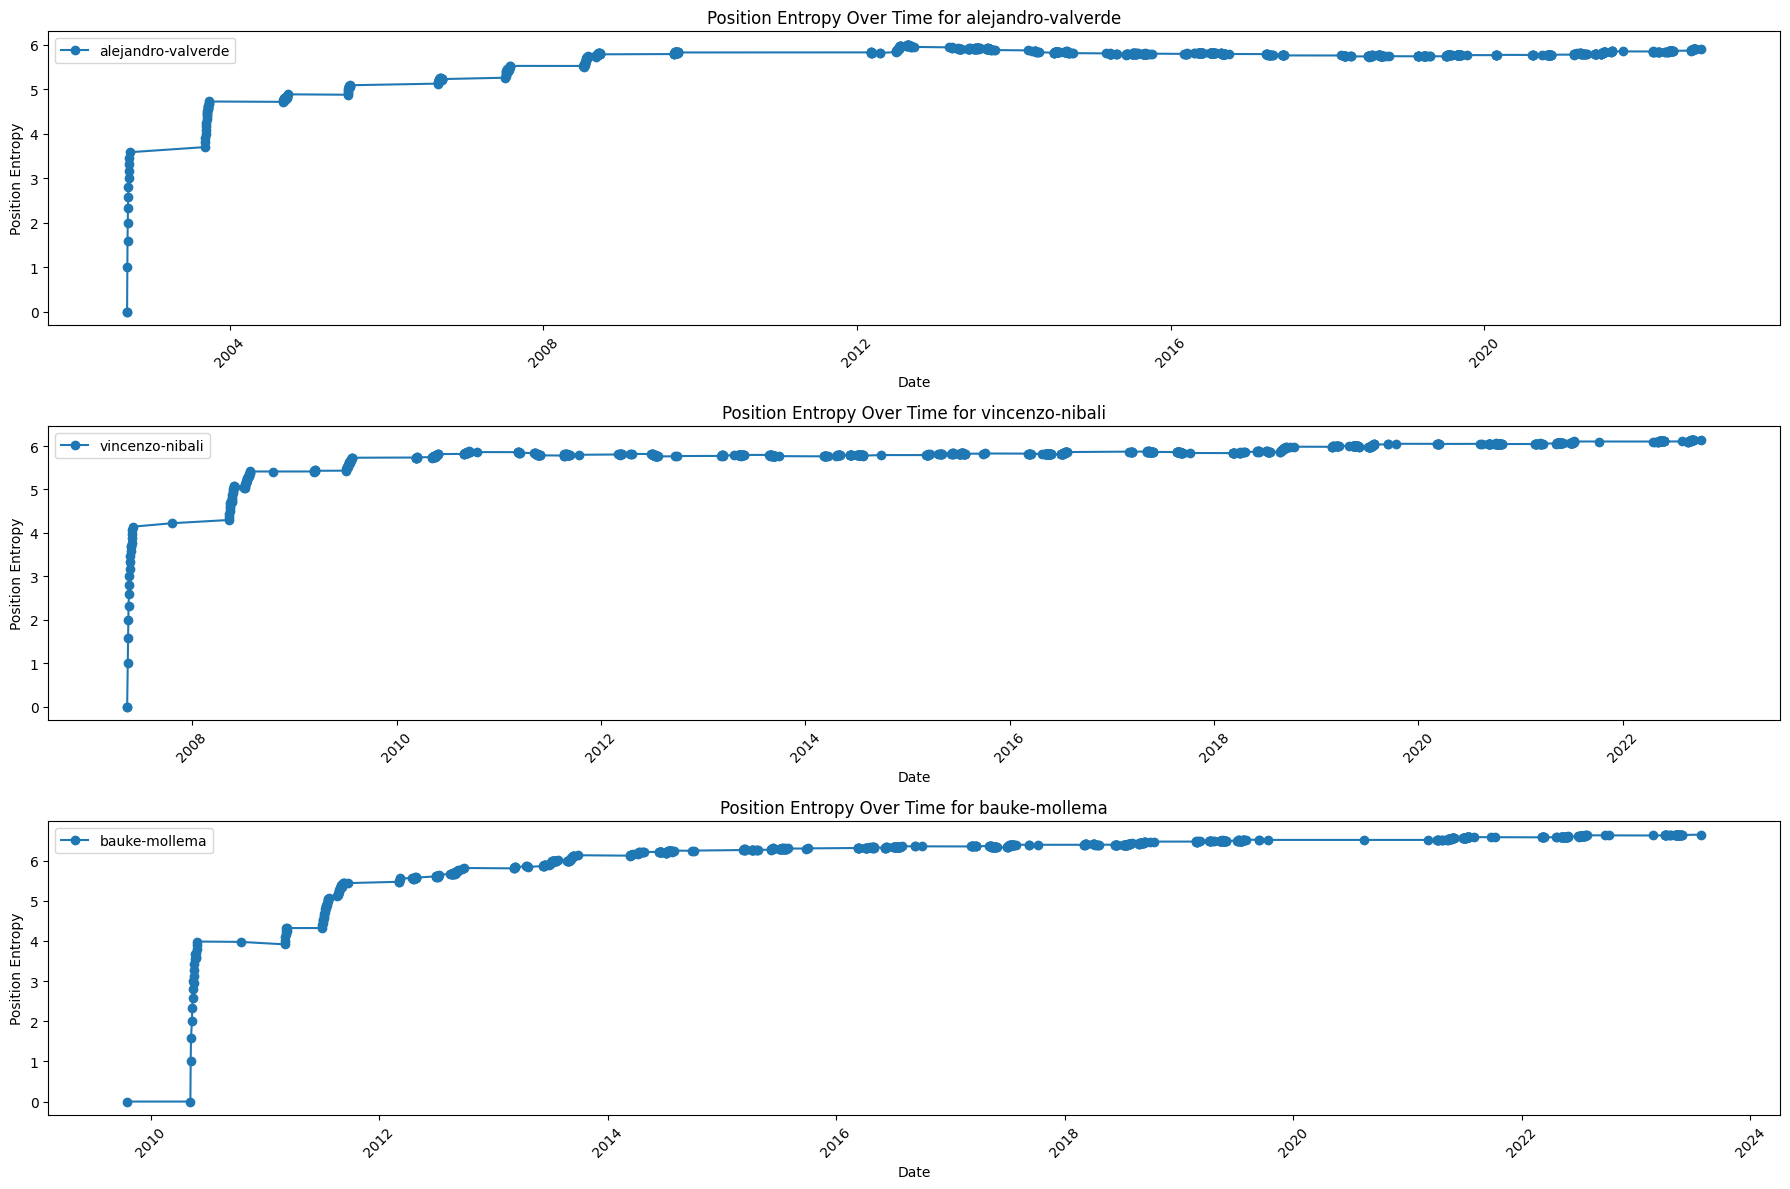

In [33]:
import matplotlib.pyplot as plt

# Filter the dataframe for the famous cyclists
famous_cyclists_df = races_df[races_df['cyclist'].isin(top_3_cyclists)]

# Plot the entropy over time for each famous cyclist in separate plots
plt.figure(figsize=(18, 12))

for i, cyclist in enumerate(top_3_cyclists, 1):
    subset = famous_cyclists_df[famous_cyclists_df['cyclist'] == cyclist]
    plt.subplot(3, 1, i)
    plt.plot(subset['start_date'], subset['position_entropy'], marker='o', label=cyclist)
    plt.xlabel('Date')
    plt.ylabel('Position Entropy')
    plt.title(f'Position Entropy Over Time for {cyclist}')
    plt.legend()
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### ```top_20_entropy```  column

This feature store the entropy in top_20 position of the cyclists in all the stages untill the one for which is computed

In [34]:
# computes cumulative entropy of cyclist positions
def calculate_entropy(positions):
    if len(positions) <= 1: 
        return 0  
    value_counts = positions.value_counts(normalize=True)  # compute probabilities 
    return entropy(value_counts, base=2)

# sort races by cyclist name and start date
races_df = races_df.sort_values(by=["cyclist", "start_date"])

# Compute entropy for each cyclists untill that race
races_df["top_20_entropy"] = (
    races_df.groupby("cyclist")["top_20"]
    .expanding()  
    .apply(lambda x: calculate_entropy(x[:-1]), raw=False)  
    .reset_index(level=0, drop=True) 
)

In [35]:
races_df[["_url", "cyclist", "start_date", "position", "position_entropy"]].head(8)


,_url,cyclist,start_date,position,position_entropy
41968,tour-de-france/1978/prologue,aad-van-den-hoek,1978-06-29,28,0.000000
117821,tour-de-france/1978/stage-1a,aad-van-den-hoek,1978-06-30,88,0.000000
174397,tour-de-france/1978/stage-1b,aad-van-den-hoek,1978-06-30,57,1.000000
331237,tour-de-france/1978/stage-2,aad-van-den-hoek,1978-07-01,47,1.584963
21609,tour-de-france/1978/stage-3,aad-van-den-hoek,1978-07-02,79,2.000000
274179,tour-de-france/1978/stage-5,aad-van-den-hoek,1978-07-04,82,2.321928
84,tour-de-france/1978/stage-6,aad-van-den-hoek,1978-07-05,84,2.584963
168634,tour-de-france/1978/stage-7,aad-van-den-hoek,1978-07-06,64,2.807355


In [36]:
# Group by cyclist and get the maximum cyclist level for each cyclist
max_cyclist_levels = races_df.groupby('cyclist')['cyclist_level'].max()

# Sort the cyclists by their maximum cyclist level in descending order and get the top 3
top_3_cyclists = max_cyclist_levels.sort_values(ascending=False).head(3).index.tolist()

for cyclist in top_3_cyclists:
    max_level = max_cyclist_levels[cyclist]
    print(f"Max cyclist level for {cyclist}: {max_level}")

Max cyclist level for alejandro-valverde: 59565.19123883357
Max cyclist level for vincenzo-nibali: 52177.729910035916
Max cyclist level for bauke-mollema: 46165.158325405624


In [37]:
vinicius_rangel_costa_df = races_df[races_df['cyclist'] == 'vincenzo-nibali']
vinicius_rangel_costa_df[["_url","points","position","cyclist_number","cyclist_level","avg_relative_position","position_entropy"]].head(10)

,_url,points,position,cyclist_number,cyclist_level,avg_relative_position,position_entropy
24235,giro-d-italia/2007/stage-2,80.0,122,194,0.000000,0.000000,0.000000
392462,giro-d-italia/2007/stage-3,80.0,90,191,29.278351,0.634021,0.000000
392578,giro-d-italia/2007/stage-4,80.0,15,190,71.163167,0.555230,1.000000
132461,giro-d-italia/2007/stage-5,80.0,60,189,144.426325,0.398224,1.584963
149193,giro-d-italia/2007/stage-6,80.0,52,186,198.606219,0.379356,2.000000
159267,giro-d-italia/2007/stage-7,80.0,59,185,255.810520,0.360474,2.321928
127715,giro-d-italia/2007/stage-8,80.0,54,180,309.864574,0.354449,2.584963
370881,giro-d-italia/2007/stage-9,80.0,63,180,365.420130,0.347464,2.807355
248289,giro-d-italia/2007/stage-10,80.0,26,171,416.975686,0.348475,3.000000
364190,giro-d-italia/2007/stage-11,80.0,45,170,484.344107,0.327300,3.169925


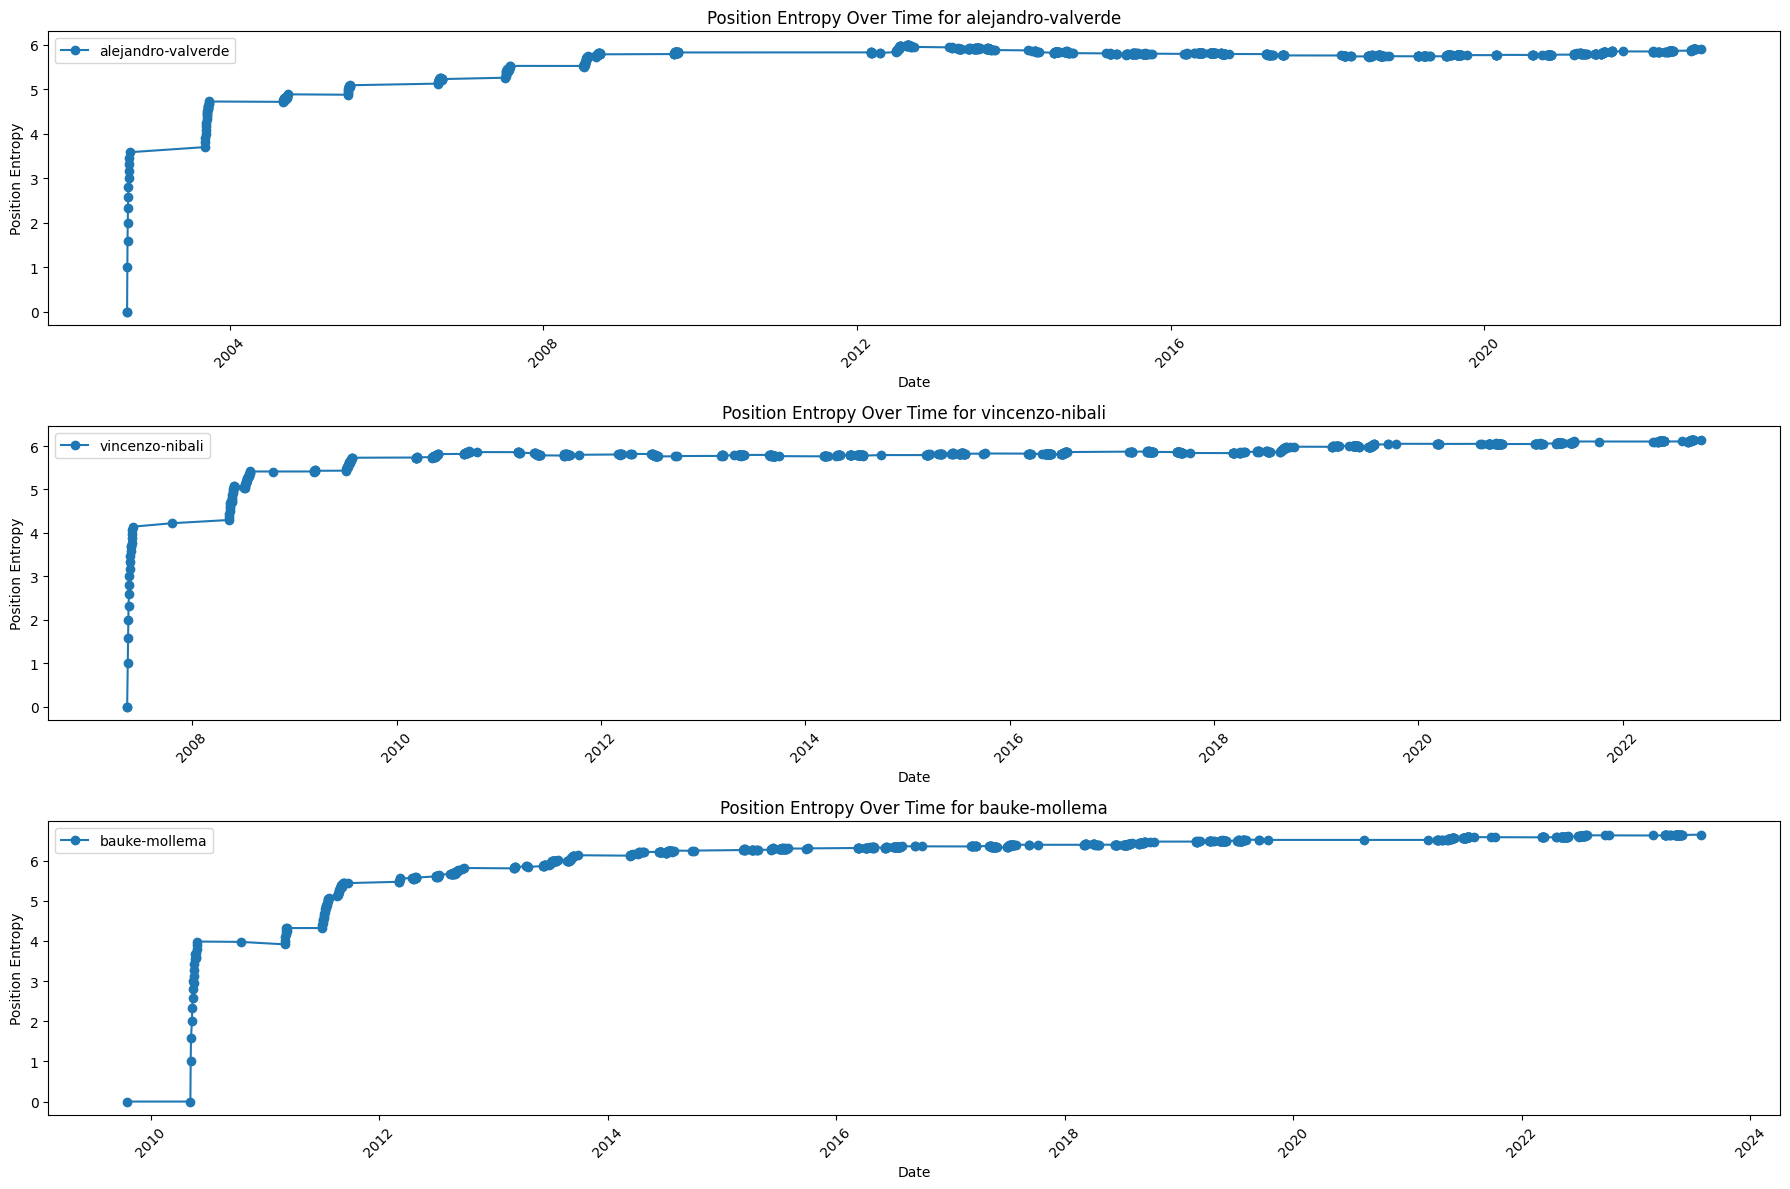

In [38]:
import matplotlib.pyplot as plt

# Filter the dataframe for the famous cyclists
famous_cyclists_df = races_df[races_df['cyclist'].isin(top_3_cyclists)]

# Plot the entropy over time for each famous cyclist in separate plots
plt.figure(figsize=(18, 12))

for i, cyclist in enumerate(top_3_cyclists, 1):
    subset = famous_cyclists_df[famous_cyclists_df['cyclist'] == cyclist]
    plt.subplot(3, 1, i)
    plt.plot(subset['start_date'], subset['position_entropy'], marker='o', label=cyclist)
    plt.xlabel('Date')
    plt.ylabel('Position Entropy')
    plt.title(f'Position Entropy Over Time for {cyclist}')
    plt.legend()
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### ```is_tarmac```  column modify

In [39]:
# Convert boolean columns to integers
races_df['is_tarmac'] = races_df['is_tarmac'].astype(int)

races_df["is_tarmac"].value_counts()

is_tarmac
1    390859
0     18145
Name: count, dtype: int64

## Dataset Preparation

Remaining columns

In [40]:
print("Column nunmber:", len(races_df.columns))
print("Columns:")
races_df.columns.tolist()

Column nunmber: 32
Columns:


['_url',
 'name',
 'points',
 'length',
 'climb_total',
 'profile',
 'startlist_quality',
 'position',
 'cyclist',
 'cyclist_age',
 'is_tarmac',
 'cyclist_team',
 'start_date',
 'duration',
 'cyclist_number',
 'top_20',
 'cyclist_level',
 'cyclist_experience',
 'relative_position',
 'avg_relative_position',
 'cyclist_experience_profile',
 'avg_rel_position_profile',
 'length_cat',
 'cyclist_experience_length',
 'avg_rel_position_length',
 'climb_cat',
 'relative_position_sum',
 'cyclist_experience_climb',
 'avg_rel_position_climb',
 'avg_cyclist_level',
 'position_entropy',
 'top_20_entropy']

### Correlation analysis

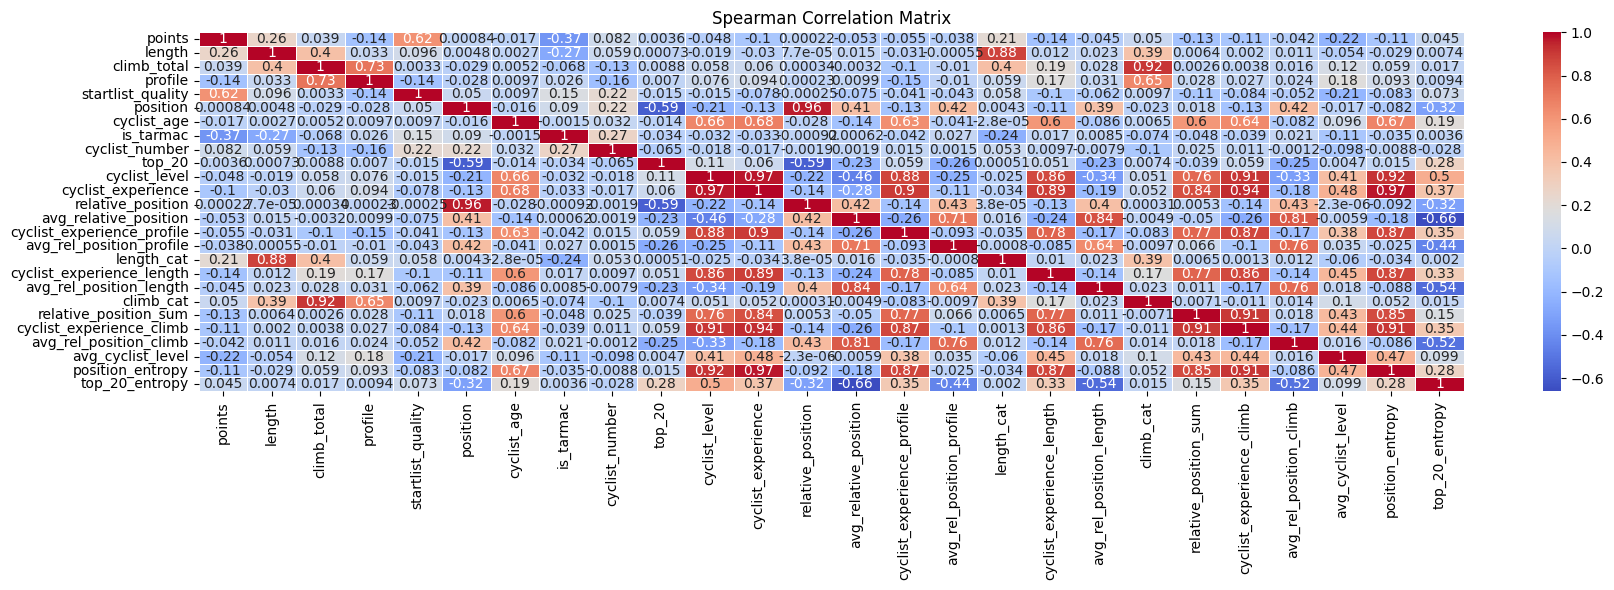

In [41]:
import sys
sys.path.append('..')
from utils import center_and_scale, correlations, plot_correlations

scaled_races_df, normalization_scalers_races = center_and_scale(races_df)
cyclists_corr = correlations(scaled_races_df, ["spearman"])
plot_correlations(cyclists_corr)

### Dropping unrelevant and correlated features

In [42]:
df = races_df.drop(columns=['_url', 'name','length', 'climb_total', 'profile', 
                            'startlist_quality', 'position', 'cyclist', 'cyclist_team', 
                            'duration','cyclist_number', 'cyclist_experience_profile',
                            'cyclist_experience_length', 'cyclist_experience_climb', 
                            'cyclist_experience', 'avg_rel_position_length', 'avg_rel_position_climb', 
                            'relative_position_sum', 'position_entropy', 'relative_position',])

### Dateset splitting according to the task

In [43]:
test_df = df[df['start_date'] >= '2020-01-01']
train_df = df[df['start_date'] < '2020-01-01']

# Drop the start_date column, now it's not needed
train_df = train_df.drop(columns=['start_date'])
test_df = test_df.drop(columns=['start_date'])

# Pick out the labels
train_labels = train_df['top_20']
test_labels = test_df['top_20']

# Drop the labels from the features
train_df = train_df.drop(columns=['top_20'])
test_df = test_df.drop(columns=['top_20'])

### Dataset Normalization

We calculate some statistics on the train and test datasets.

In [44]:
print("Training data percentage of overall data:", round(train_df.shape[0] / df.shape[0], 2))

Training data percentage of overall data: 0.84


In [45]:
train_labels.value_counts(normalize=True)

top_20
0    0.86791
1    0.13209
Name: proportion, dtype: float64

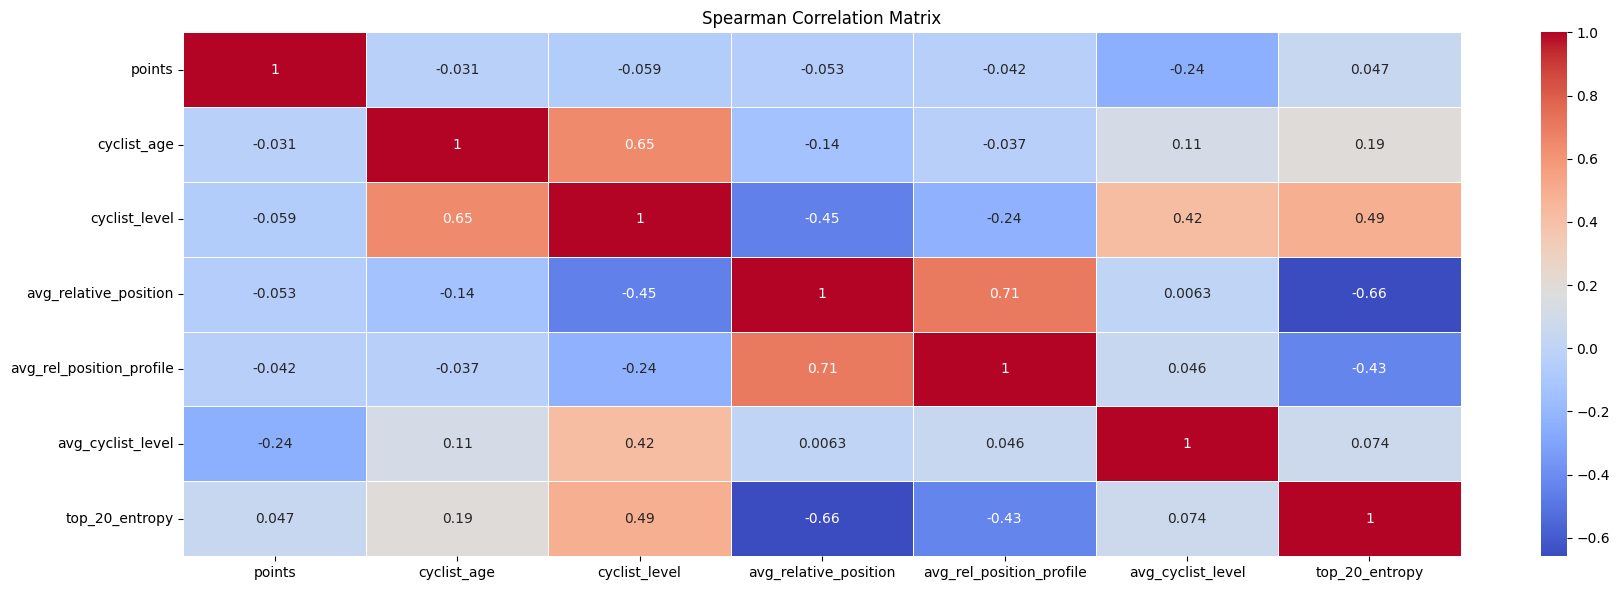

In [46]:
scaled_train_df, normalization_scalers_races = center_and_scale(train_df)
train_corr = correlations(scaled_train_df.drop(columns=["is_tarmac","length_cat","climb_cat"]), ["spearman"])

plot_correlations(train_corr)

In [47]:
print("test data percentage of overall data:", round(test_df.shape[0] / df.shape[0], 2))

test data percentage of overall data: 0.16


In [48]:
test_labels.value_counts(normalize=True)

top_20
0    0.856025
1    0.143975
Name: proportion, dtype: float64

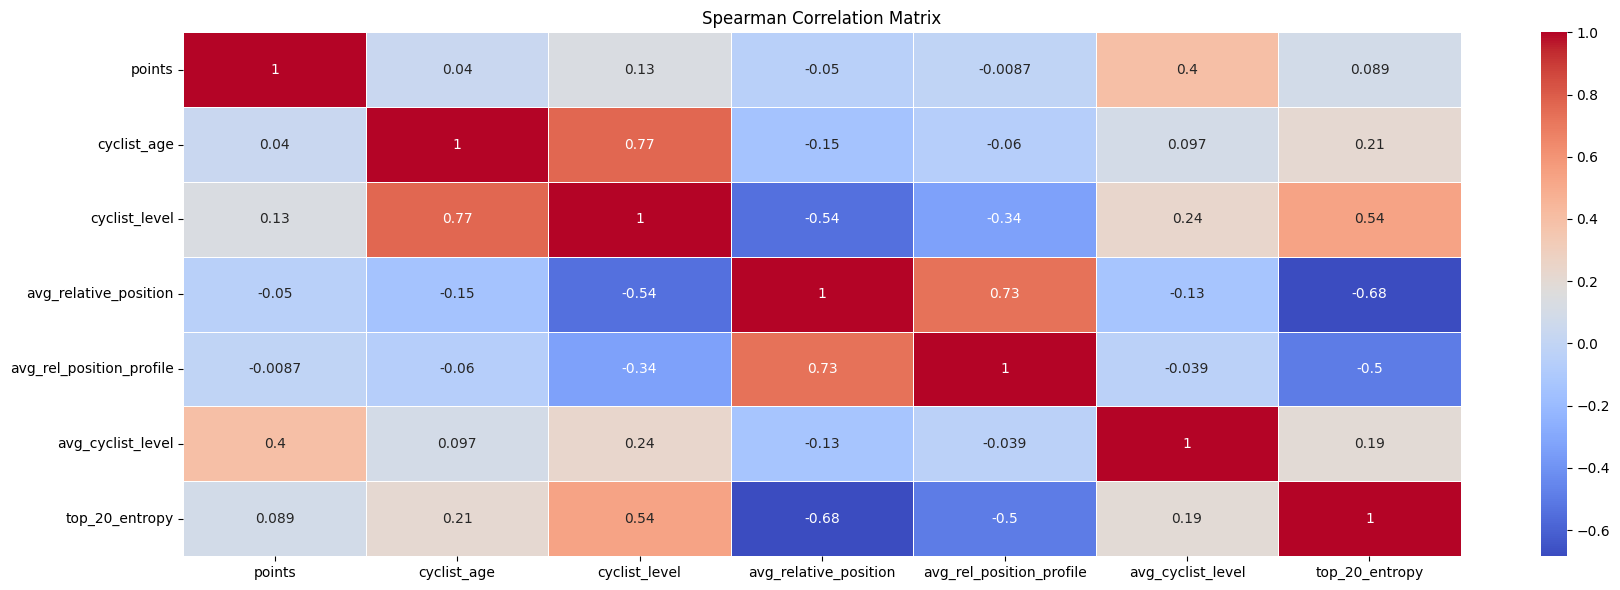

In [49]:
scaled_test_df, normalization_scalers_races = center_and_scale(test_df)
test_corr = correlations(scaled_test_df.drop(columns=["is_tarmac","length_cat","climb_cat"]), ["spearman"])

plot_correlations(test_corr)

### Save Dataset

The dataset is saved not scaled because of three categorical features, preserved for algorithms who needs them.
Categorical features are ```is_tarmac```, ```length_cat``` and ```climb_cat``` columns.

In [50]:
# save test and train data
train_df.to_csv('../dataset/train_data.csv', index=False)
test_df.to_csv('../dataset/test_data.csv', index=False)

# save test and train labels
train_labels.to_csv('../dataset/train_labels.csv', index=False)
test_labels.to_csv('../dataset/test_labels.csv', index=False)